In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn 
from torch.nn import functional as F 
import math
import os
import time
import inspect
import matplotlib.pyplot as plt
%matplotlib inline 

In [38]:

class CasualSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q, k ,v = qkv.split(self.n_embd, dim=2)
        # print("q", q.size(), q[0][0], "k", k[0][0], "v", v[0][0],)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, head, T, headsize)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) 
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) 
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # print("y", y.size(), y, )
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # print("y aft", y.size(), y, )
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CasualSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass 
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 6 #12
    n_head: int = 8 #12
    n_embd: int = 8 #768

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config 

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd), 
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):

        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of the length {T}, block size of {B}"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  #(T)
        pos_emb = self.transformer.wpe(pos) #(T, n_emb)
        tok_emb = self.transformer.wte(idx)  #(B, T, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretraied GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weight from pretrained gpt: %s" % model_type)

        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),   #124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024),  #350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280),  #774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600),  #124M params
        }[model_type]
        config_args['vocab_size'] = 50257  
        config_args['block_size'] = 1024

        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] 

        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # ignore these, just a buffer
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                # if sd_hf[k].shape[::-1] != sd[k].shape:
                #     print(f"Shape mismatch for key {k}: HF shape {sd_hf[k].shape}, expected {sd[k].shape[::-1]}")
                #     continue  # or handle appropriately
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model
    
    def configure_optimizers(self, weight_decay, learning_rate, device):
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer
    
#--------DETECT THE DEVICE ---------------
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = 'mps'
# device = 'cpu'
print(f"using device: {device}")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
#--------DETECT THE DEVICE ---------------

using device: cpu


In [39]:
import tiktoken
import numpy as np 
import math, time

def load_tokens(filename):
    npt = np.load(filename)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt


class DataLoaderLite:
        
    def __init__(self, B, T, split):
        self.B = B 
        self.T = T
        self.split = split
        text = open('../input.txt', 'r').read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)        

        self.tokens = torch.tensor(tokens)
        # print(f"loaded {len(self.tokens)} tokens")
        # print(f"1 epoch = {len(self.tokens) // (B * T)} batches")
        self.total_tokens =len(self.tokens)

        self.current_position = 0
        self.max_position = self.total_tokens - (B * T + 1)
        self.batches_per_epoch = self.max_position // (B*T)
        print(f"[{self.split}] Loaded {self.total_tokens} tokens from length {len(text)}")
        print(f"[{self.split}] 1 epoch = {self.batches_per_epoch} batches")

        # self.count = 0  #debug
    
    def reset(self):
        self.tokens = self.tokens
        self.current_position = self.B * self.T 
    
    def next_batch(self):
        B, T = self.B, self.T
        if self.current_position > self.max_position:
            # raise StopIteration("Epoch complete") 
            return None

        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        # print(f"position: [{self.current_position}], count: {self.count}")
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B, T)
        self.current_position += B*T
        # self.count+=1  #debug
        return x, y

In [40]:
## GRAPH================================

class ActivDist:

    def __init__(self, W, H):
        self.figsize = (W, H)
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.lines = []  # store plot lines for hover interaction
        self.legends = []
        self.annotation = None
        plt.ion()
    
    def on_motion(self, event):
        """Handle mouse hover to show layer info"""
        if event.inaxes != self.ax:
            if self.annotation.set_visible(False):
                self.fig.canvas.draw_idle()
            return

        for line, legend in zip(self.lines, self.legends):
            if line.contains(event)[0]:
                x, y = event.xdata, event.ydata
                if self.annotation is None:
                    self.annotation = self.ax.annotate(
                        legend, xy=(x, y), xytext=(5, 5),
                        textcoords="offset points", ha="left", va="bottom",
                        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8)
                    )
                else:
                    self.annotation.set_text(legend)
                    self.annotation.xy = (x, y)
                    self.annotation.set_visible(True)
                self.fig.canvas.draw_idle()
                return
            if self.annotation is not None:
                self.annotation.set_visible(False)
                self.fig.canvas.draw_idle()
         

    def figure(self, layers, step):
        self.ax.clear()
        self.lines.clear()
        self.legends.clear()

        for i, (name, t) in enumerate(activations.items()):
                t = t.to(torch.float32)
                print('layer %d(10%s): mean %+.2f, std %.2f, satured: %2.f%%' % (
                    i, name, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
                hy, hx = torch.histogram(t, bins=100, density=True)
                line, = self.ax.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i} ({name})")
                self.ax.plot(hx[:-1].detach(), hy.detach())
                self.lines.append(line)
                self.legends.append(f"layer {i} ({name})")

        self.ax.legend(self.legends)
        self.ax.set_title(f'{step} - activation distribution')
        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

        # connect the hover event
        if not hasattr(self, 'cid'):
            self.cid = self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

activations = {}
gradients = {}



def forward_hook(module, input, output, name):
    activations[module] = output.detach()
    # print('Activation', output)

def backward_hook(module, grad_input, grad_output, name):
    #grad_output is a tuple; take the first element
    gradients[module] = grad_output[0].detach()
    # print("gradient of output:", grad_output)



In [43]:
model = GPT(GPTConfig(vocab_size=50304))
model.to(device)

max_lr = 0.1 #6e-4
min_lr = max_lr * 0.1
warmup_steps = 100
max_steps = 201
enc = tiktoken.get_encoding('gpt2')

total_batch_size = 2 * 32
B = 2
T = 16
grad_accum_steps = total_batch_size // (B * T)
train_loader = DataLoaderLite(B=B, T=T, split="train")  #4x32
val_loader = DataLoaderLite(B=B, T=T, split="val")  #4x32

def get_lr(it):
    if it < warmup_steps:
        # x = max_lr * (it+1) / warmup_steps
        # print("ir warmup", x)
        return max_lr * (it+1) / warmup_steps
    
    if it > max_steps:
        return min_lr
    
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

for name, module in model.named_modules():
    if isinstance(module, nn.GELU):
        print(f"[HOOK] Registering GELU at {name} module:{module}")
        module.register_forward_hook(lambda m, i, o, n=name: forward_hook(m, i, o, n))
        module.register_full_backward_hook(lambda m, gi, go, n=name: backward_hook(m, gi, go, n))

[train] Loaded 338025 tokens from length 1115394
[train] 1 epoch = 10562 batches
[val] Loaded 338025 tokens from length 1115394
[val] 1 epoch = 10562 batches
num decayed parameter tensors: 26, with 415,232 parameters
num non-decayed parameter tensors: 50, with 640 parameters
using fused AdamW: False
[HOOK] Registering GELU at transformer.h.0.mlp.gelu module:GELU(approximate='tanh')
[HOOK] Registering GELU at transformer.h.1.mlp.gelu module:GELU(approximate='tanh')
[HOOK] Registering GELU at transformer.h.2.mlp.gelu module:GELU(approximate='tanh')
[HOOK] Registering GELU at transformer.h.3.mlp.gelu module:GELU(approximate='tanh')
[HOOK] Registering GELU at transformer.h.4.mlp.gelu module:GELU(approximate='tanh')
[HOOK] Registering GELU at transformer.h.5.mlp.gelu module:GELU(approximate='tanh')


Validation loss: 5.6103
> Hello, I'm a language model,  areIUS:

OL it him,IIf not
SAN
MENAN
COR:

> Hello, I'm a language model,  not;

MEN:
US:
That,ENIUS:
MEN the their,
US
> Hello, I'm a language model, IC are
AN
C have to them that beIC are, the and!
MEN
BR:

> Hello, I'm a language model, 'dAN
BRTo-- your the
US:
OL.
MEN toEN
SEN
I
step: 0 |loss 5.759817123413086 | lr=0.0010 | dt: 2222.30 | token processed: 64 | tokens per sec: 0.0288
layer 0(10GELU(approximate='tanh')): mean -0.00, std 0.03, satured:  0%
layer 1(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 2(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 3(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 4(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 5(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 6(10GELU(approximate='tanh')): mean +2.31, std 4.18, satured: 31%
layer 7(10GELU(approximate='tanh')): mean -0.02, st

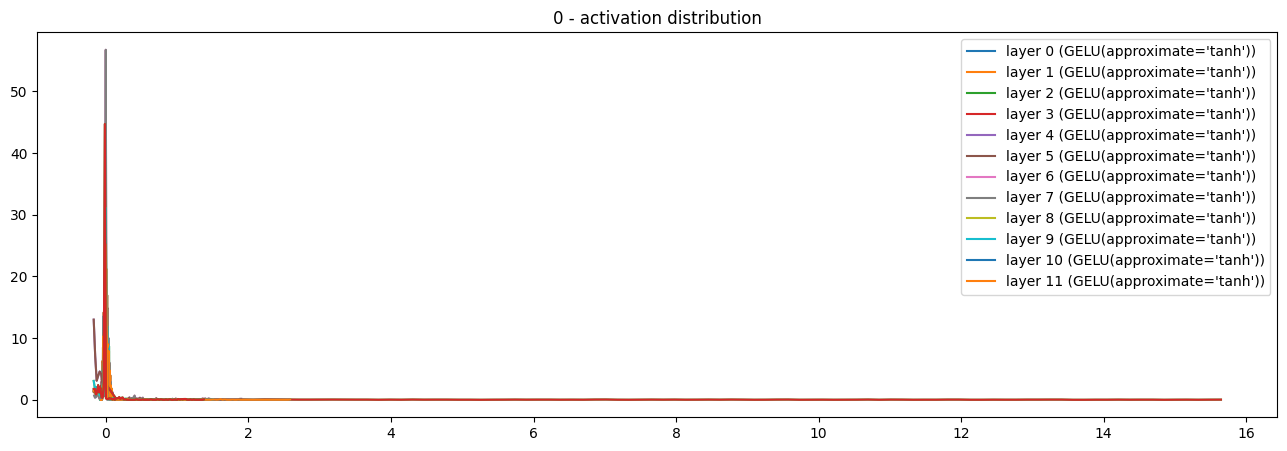

layer 0(10GELU(approximate='tanh')): mean -0.00, std 0.03, satured:  0%
layer 1(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 2(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 3(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 4(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 5(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 6(10GELU(approximate='tanh')): mean +2.31, std 4.18, satured: 31%
layer 7(10GELU(approximate='tanh')): mean -0.02, std 0.31, satured:  3%
layer 8(10GELU(approximate='tanh')): mean +0.01, std 0.12, satured:  0%
layer 9(10GELU(approximate='tanh')): mean -0.02, std 0.09, satured:  0%
layer 10(10GELU(approximate='tanh')): mean +0.02, std 0.23, satured:  2%
layer 11(10GELU(approximate='tanh')): mean +0.01, std 0.17, satured:  2%
Validation loss: 5.9418
> Hello, I'm a language model, :

IC.
S seem your,
 thusICI
US:
As had with!

> Hello, I'm a language model, :

<Figure size 640x480 with 0 Axes>

layer 0(10GELU(approximate='tanh')): mean -0.00, std 0.03, satured:  0%
layer 1(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 2(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 3(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 4(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 5(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 6(10GELU(approximate='tanh')): mean +2.44, std 3.71, satured: 38%
layer 7(10GELU(approximate='tanh')): mean -0.03, std 0.12, satured:  0%
layer 8(10GELU(approximate='tanh')): mean -0.00, std 0.00, satured:  0%
layer 9(10GELU(approximate='tanh')): mean -0.00, std 0.01, satured:  0%
layer 10(10GELU(approximate='tanh')): mean -0.00, std 0.02, satured:  0%
layer 11(10GELU(approximate='tanh')): mean -0.00, std 0.03, satured:  0%
Validation loss: 5.7607
> Hello, I'm a language model,  for have
O of
SecondINIUS: pray's
MEN to it have he so their than,
> Hello, I'

<Figure size 640x480 with 0 Axes>

layer 0(10GELU(approximate='tanh')): mean -0.00, std 0.03, satured:  0%
layer 1(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 2(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 3(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 4(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 5(10GELU(approximate='tanh')): mean +0.00, std 0.03, satured:  0%
layer 6(10GELU(approximate='tanh')): mean +2.34, std 4.08, satured: 32%
layer 7(10GELU(approximate='tanh')): mean -0.00, std 0.00, satured:  0%
layer 8(10GELU(approximate='tanh')): mean -0.00, std 0.00, satured:  0%
layer 9(10GELU(approximate='tanh')): mean -0.00, std 0.00, satured:  0%
layer 10(10GELU(approximate='tanh')): mean -0.00, std 0.00, satured:  0%
layer 11(10GELU(approximate='tanh')): mean -0.01, std 0.04, satured:  0%


In [47]:

pltactivation = ActivDist(16, 5)

lossi = []
ud = []
parameters = [p for layer in model.modules() for p in layer.parameters()]

for i in range(max_steps):
    t0 = time.time()
    last_step = (i == max_steps -1)

    ## VALIDATE
    if i % 100 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 5
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss /  val_loss_steps
                val_loss_accum += loss.detach()
        print(f"Validation loss: {val_loss_accum.item():.4f}")

    ## GENERATION
    if i % 100 == 0:
        model.eval()
        num_return_sequence = 4
        max_length = 32
        tokens = enc.encode("Hello, I'm a language model, ")
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequence, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42)
        while xgen.size(1) < max_length:
            with torch.no_grad():
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(xgen)
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng)
                xcol = torch.gather(topk_indices, -1, ix)
                xgen = torch.cat((xgen, xcol), dim=1)
        for j in range(num_return_sequence):
            tokens = xgen[j, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(">", decoded)
        

    model.train()
    optimizer.zero_grad()
    loss_accum = 0
   
    for micro_step in range(grad_accum_steps):
        batch = train_loader.next_batch()
        if batch is None:
            print("Epoch complete — stopping training or restarting loader")
            break
        x, y = batch
        x, y = x.to(device), y.to(device)
        

        with torch.autocast(device_type=device, dtype=torch.float16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
        lossi.append(loss.log10().item())


    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    lr = get_lr(i)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.step()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t1 = time.time()    
    dt = (t1-t0)*1000
    if dt == 0:
        dt = 3e-8
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tokens_per_sec = tokens_processed / dt 

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])  #(STEP, PARAMETERS)
        """ 
        relative size of the update compared to parameter's scale
        convert this ratio to log base 10 and extract as Python float
        store the log-relative update for each parameter at each step
        """
        
    if i % 100 == 0:
        print(f"step: {i} |loss {loss_accum} | lr={lr:.4f} | dt: {dt:.2f} | token processed: {tokens_processed} | tokens per sec: {tokens_per_sec:.4f}")
               
        
        # pltactivation.figure(model.modules(), i)
        pltactivation.figure(activations, i)
        plt.draw()
        plt.pause(0.01)

        for name, layer in model.named_modules():
            if isinstance(name, nn.GELU):

                if layer not in activations:
                    print(f"[MISSING] {layer} missing from activations dict")
                    continue
                act = activations[layer]
                print(f"{name} activation: mean {act.mean():.4f}, std {act.std():.4f}, shape {act.shape}")
                
                if name in gradients:
                    grad = gradients[name]
                    print(f"{name} gradient: mean {grad.mean():.4f}, std {grad.std():.4f}, shape {grad.shape}")
                else:
                    print(f"[MISSING] {name} missing from gradients dict")

        pltactivation.figure(activations, i)
        plt.pause(0.01)


plt.ioff()
plt.show()

In [45]:
activations

{GELU(approximate='tanh'): tensor([[[-0.0351, -0.0459, -0.0182,  ...,  0.0031, -0.0396,  0.0113],
          [ 0.0061, -0.0488, -0.0177,  ...,  0.0191, -0.0230, -0.0166],
          [-0.0002, -0.0399, -0.0125,  ...,  0.0064, -0.0467,  0.0233],
          ...,
          [-0.0388,  0.0025,  0.0561,  ..., -0.0101, -0.0190, -0.0268],
          [ 0.0042, -0.0440, -0.0239,  ..., -0.0108, -0.0156,  0.0138],
          [ 0.0093, -0.0178, -0.0056,  ..., -0.0145,  0.0022,  0.0354]],
 
         [[ 0.0017, -0.0275, -0.0453,  ...,  0.0011, -0.0352,  0.0188],
          [-0.0276, -0.0241, -0.0134,  ...,  0.0175, -0.0500, -0.0077],
          [ 0.0107, -0.0599,  0.0011,  ...,  0.0049, -0.0217, -0.0016],
          ...,
          [-0.0283,  0.0194,  0.0475,  ..., -0.0174, -0.0173,  0.0132],
          [ 0.0419, -0.0197, -0.0028,  ..., -0.0202,  0.0313,  0.0559],
          [ 0.0005, -0.0028,  0.0366,  ..., -0.0116,  0.0249,  0.0275]]],
        dtype=torch.float16),
 GELU(approximate='tanh'): tensor([[[ 2.3926e